This colab notebook contains an analysis example using [DrivAER](https://github.com/lkmklsmn/DrivAER). The code evaluates DrivAER in simulated scRNAseq data.

Install all required packages. This may take ~5(!) minutes.

In [ ]:
%%capture
!pip install git+https://github.com/lkmklsmn/DrivAER.git
!pip install scanpy==1.4.6
!pip install tensorflow-gpu==1.15.4
!pip install keras==2.3.1

Import required packages.

In [ ]:
%%capture
import DrivAER as dv
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import warnings
sc.settings.verbosity = 1
sc.logging.print_versions()
warnings.filterwarnings("ignore")

Download and load the Scanpy AnnData object containing the simulated scRNAseq data.

In [ ]:
%%capture
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1rYQk2U3ZbkPJou6D6podHTUeNRSJWSQ8' -O "two_group_simulation_gene_info.csv"
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1U4GIXV5F4KDEdrjZAlgagelknOn4B7gy' -O "two_group_simulation_counts.csv"
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1unW1LeOeXtym6isZHWIrV7PS8Wsg62ds' -O "two_group_simulation_cell_info.csv"

In [ ]:
ls

sample_data/                        two_group_simulation_counts.csv
two_group_simulation_cell_info.csv  two_group_simulation_gene_info.csv


In [ ]:
adata = sc.read('two_group_simulation_counts.csv').T
adata.obs = pd.read_csv('two_group_simulation_cell_info.csv')
gene_info = pd.read_csv('two_group_simulation_gene_info.csv')
adata.var['DE'] = np.array(gene_info['DEFacGroup1'] == gene_info['DEFacGroup2'])
adata

AnnData object with n_obs × n_vars = 2000 × 500
    obs: 'Unnamed: 0', 'Cell', 'Batch', 'Group', 'ExpLibSize', 'sizeFactor'
    var: 'DE'

Define function to create gene sets with varying levels of noise.

In [ ]:
def generate_simulated_geneset_2(fraction = 0.9):
    df = adata.var.copy()
    genes_nonde = df[df['DE'] == 1].index.tolist()
    genes_de = df[df['DE'] != 1].index.tolist()
    geneset = np.random.choice(np.array(genes_de), round(len(genes_de) * fraction), replace = False).tolist()
    random = np.random.choice(np.array(genes_nonde), round(len(genes_de) * (1 - fraction)), replace = False).tolist()
    geneset += random
    return geneset

genesets = []
for i in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
  for x in range(0, 10):
    genesets.append(generate_simulated_geneset_2(i))

Run DrivAER

In [ ]:
%%time
res = dv.calc_relevance(count=adata, pheno = adata.obs['Group'], ae_type='zinb-conddisp', 
                        tf_targets = pd.Series(genesets), epochs = 100, early_stop = 3, min_targets=1, verbose = False)

Normalize data

In [ ]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [ ]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import StandardScaler
import numbers
import scipy
from DrivAER.rele_score import calc_relevance_pca, calc_relevance_tsne, calc_relevance_umap

Run DrivAER using PCA, tSNE and UMAP for dimension reduction

In [ ]:
%%time
res_pca = calc_relevance_pca(adata=adata, pheno = adata.obs['Group'], tf_targets = pd.Series(genesets), min_targets=1)
res_tsne = calc_relevance_tsne(adata=adata, pheno = adata.obs['Group'], tf_targets = pd.Series(genesets), min_targets=1)
res_umap = calc_relevance_umap(adata=adata, pheno = adata.obs['Group'], tf_targets = pd.Series(genesets), min_targets=1)

CPU times: user 44min 13s, sys: 26.6 s, total: 44min 40s
Wall time: 28min 42s


Compare accuracies across different dimension reduction techniques

In [ ]:
fraction = []
for i in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
  fraction += [i]*10

accuracies = pd.DataFrame({'fraction':fraction, 'drivaer':res[1], 'pca':res_pca[1], 'umap':res_umap[1], 'tsne':res_tsne[1]})
accuracies.to_csv('accuracies.csv')

In [ ]:
combined_res=[]
for i in [res[1], res_pca[1], res_umap[1], res_tsne[1]]:
  combined_res += list(i)

method=[]
for i in ['drivaer', 'pca', 'umap', 'tsne']:
  method += [i] * len(genesets)

In [ ]:
combined_res=[]
for i in [accuracies['drivaer'], accuracies['pca'], accuracies['umap'], accuracies['tsne']]:
  combined_res += list(i)
method = []
for i in ['drivaer', 'pca', 'umap', 'tsne']:
  method += [i] * 60
fraction = []
#for i in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
for i in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
  fraction += [i]*10

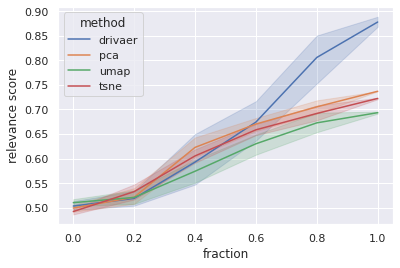

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
accs = pd.DataFrame({'fraction': fraction * 4, 'relevance score': combined_res, 'method': method})
ax = sns.lineplot(x="fraction", y="relevance score", hue="method", data=accs)

Run DrivAER with different bottleneck configurations

In [ ]:
adata = sc.read('two_group_simulation_counts.csv').T
adata.obs = pd.read_csv('two_group_simulation_cell_info.csv')
gene_info = pd.read_csv('two_group_simulation_gene_info.csv')
adata.var['DE'] = np.array(gene_info['DEFacGroup1'] == gene_info['DEFacGroup2'])
adata

AnnData object with n_obs × n_vars = 2000 × 500
    obs: 'Unnamed: 0', 'Cell', 'Batch', 'Group', 'ExpLibSize', 'sizeFactor'
    var: 'DE'

In [ ]:
%%time
res_2 = dv.calc_relevance(count=adata, pheno = adata.obs['Group'], ae_type='zinb-conddisp', hidden_size=(8, 2, 8),
                        tf_targets = pd.Series(genesets), epochs = 100, early_stop = 3, min_targets=1, verbose = False)
res_4 = dv.calc_relevance(count=adata, pheno = adata.obs['Group'], ae_type='zinb-conddisp', hidden_size=(16, 4, 16),
                        tf_targets = pd.Series(genesets), epochs = 100, early_stop = 3, min_targets=1, verbose = False)
res_8 = dv.calc_relevance(count=adata, pheno = adata.obs['Group'], ae_type='zinb-conddisp', hidden_size=(16, 8, 16),
                        tf_targets = pd.Series(genesets), epochs = 100, early_stop = 3, min_targets=1, verbose = False)

In [ ]:
accs = pd.DataFrame({'fraction': fraction, 'hidden_size2': res_2[1],'hidden_size4': res_4[1], 'hidden_size8': res_8[1]})
accs.to_csv('hidden_size_diff_accuracies.csv')